![alt text](gisma_logo.png "logo")

<h1><center>M508: NLP Pipeline</center></h1>
<h5><center>Submitted by: Faiz Qureshi, GH1018786
<h5><center>Module Leader: Prof. Dr. Mohammad Mahdavi

![alt text](ai_music.jpeg "logo")

<h1><center>LYRGEN: ML Based Lyric Generation</center></h1>

# Table of contents

- <a href='#1'>Context </a> 
- <a href='#2'>Problem Statement </a> 
- <a href='#3'>Approach </a> 
- <a href='#4'>Data Exploration </a> 
- <a href='#5'>Data Preparation </a> 
- <a href='#6'>Modeling </a>
- <a href='#7'>Evaluation </a> 
- <a href='#8'>Text Generation</a> 
- <a href='#9'>Conclusion </a>
- <a href='#10'>References </a>


# <a id='1'>Context<a>


As the availability of data and compute resources drive Deep Learning further than before, there is now a focus of using AI in more creative domains. One of these is to try and build systems to automatically generate prose, poems and lyrics. There is strong commercial scope as well. AI generated music and music videos are being used to augment record label portfolios. The objective is to tell an AI what is needed for a specific project - for example a background score for a particular scene in a movie and have the AI "compose" multiple options for us quickly.

I work for one such record label, which is focused on using AI powered systems for creative endeavours. Recently, I was tasked with building an initial pipeline to test the scope of lyric generation using NLP. If promising, further resources will be allocated by the label to produce a SOTA system which will then be used along with similar music generation software. Though music can be a very subjective topic, needless to say, the first label to churn out "good" music developed using AI will see major commercial returns.



# <a id='2'>Problem Statement <a>



The task at hand is to use existing lyrics as a base for teaching an ML model how to generate lyrics. Once trained, the model should be able to produce coherent lyrics based on an initial prompt. Let us try to break this problem into its simples form.

If we are given an input to seed from, we need to predict which word needs to follow this seed text. Assuming we make a good prediction, we can simply used the original text, plus the predicted word as the seed text to get the next prediction. This process can be repeated until our required number of words is reached.

In essence, we are dealing with a next-word prediction problem, where our current state is the text we have already generated so far.

Typically text carries contextual information through the order in which words are combined to form this text. Something like this is a good candidate for a Recurrent Neural Network (like LSTM) which uses sequences to form states, which can help predicting the next unit in a sequence.


# <a id='3'>Approach<a>


### Limitations
- We have limited turnaround time to check viability
- We also have limited compute resources
- The aim of this pipeline is not to be SOTA, but to prove the viability of an ML based solution

### Data
Though it is easy to get access to lyrics for millions of songs thanks to the internet, for this pilot effort, we will start small. Deep learning models are known to benefit from increasing amounts of data, so if we can build something even moderately viable using a small corpus, we can definitely improve on it in subsequent phases.

Thus, we will use a small sample from a dataset sourced from Kaggle (https://www.kaggle.com/datasets/karnikakapoor/lyrics).

For ease of use, I have also hosted this data on a Github repo. Let us get started!


# <a id='4'>Data Exploration<a>


Let us load the data using Github and begin exploring it.

We will begin by importing the basic libraries for data loading and exploration. 


***Please note that we will only be importing libraries in the cells just before they are needed. This is a personal choice, but I find it much more helpful to have relecant imports within sight of the cells I am working on.***

In [89]:
# Suppress warnings
import warnings
import os
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
%matplotlib inline


# Dataset handling and exploration
import pandas as pd
import numpy as  np
import matplotlib.pyplot as plt
import seaborn as sns


In [62]:
data_url = r'https://raw.githubusercontent.com/FzQureshi/Datasets/main/Songs.csv'
all_lyrics = pd.read_csv(data_url)
all_lyrics.head()

,Artist,Title,Lyrics
0,Taylor Swift,cardigan,"Vintage tee, brand new phone\nHigh heels on co..."
1,Taylor Swift,exile,"I can see you standing, honey\nWith his arms a..."
2,Taylor Swift,Lover,We could leave the Christmas lights up 'til Ja...
3,Taylor Swift,the 1,"I'm doing good, I'm on some new shit\nBeen say..."
4,Taylor Swift,Look What You Made Me Do,I don't like your little games\nDon't like you...


In [63]:
all_lyrics.describe()

,Artist,Title,Lyrics
count,745,745,745
unique,21,742,745
top,Taylor Swift,Autumn Leaves,"Vintage tee, brand new phone\nHigh heels on co..."
freq,50,3,1


In [64]:
all_lyrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 745 entries, 0 to 744
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Artist  745 non-null    object
 1   Title   745 non-null    object
 2   Lyrics  745 non-null    object
dtypes: object(3)
memory usage: 17.6+ KB


The data is quite simple. We only have 745 rows and 3 columns (Artist, Title and Lyrics of the song). Let us check which Artists are included.

In [65]:
all_lyrics['Artist'].value_counts()

Taylor Swift          50
David Bowie           50
Billy Joel            50
Eric Clapton          50
Billie Eilish         50
Leonard Cohen         50
Bruce Springsteen     40
The Beatles           35
Ray LaMontagne        30
Elton John            30
Queen                 30
Frank Sinatra         30
John Denver           30
Bryan Adams           30
​twenty one pilots    30
Nat King Cole         30
Lana Del Rey          30
Vance Joy             30
George Michael        30
Bob Dylan             20
Ed Sheeran            20
Name: Artist, dtype: int64

As seen, there are 21 unique artists with 20 to 50 songs each. 

We are most interested in the lyrics column, so let us explore that further.

In [66]:
# Add info for numf of chars, words and lines in each song
all_lyrics["num_chars"] = all_lyrics["Lyrics"].apply(len)
all_lyrics["num_words"] = all_lyrics.apply(lambda row: row["Lyrics"].split(" "), axis=1).apply(len)
all_lyrics["num_lines"] = all_lyrics["Lyrics"].str.split('\n').apply(len)
all_lyrics.describe()

,num_chars,num_words,num_lines
count,745.000000,745.000000,745.000000
mean,1403.347651,235.240268,46.277852
std,666.721467,112.549344,21.180531
min,1.000000,1.000000,1.000000
25%,946.000000,159.000000,33.000000
50%,1289.000000,216.000000,44.000000
75%,1714.000000,288.000000,56.000000
max,7267.000000,1219.000000,224.000000


The average song in the corpus has about 1400 chars, 235 words and 46 lines. Let us break it down by artists.

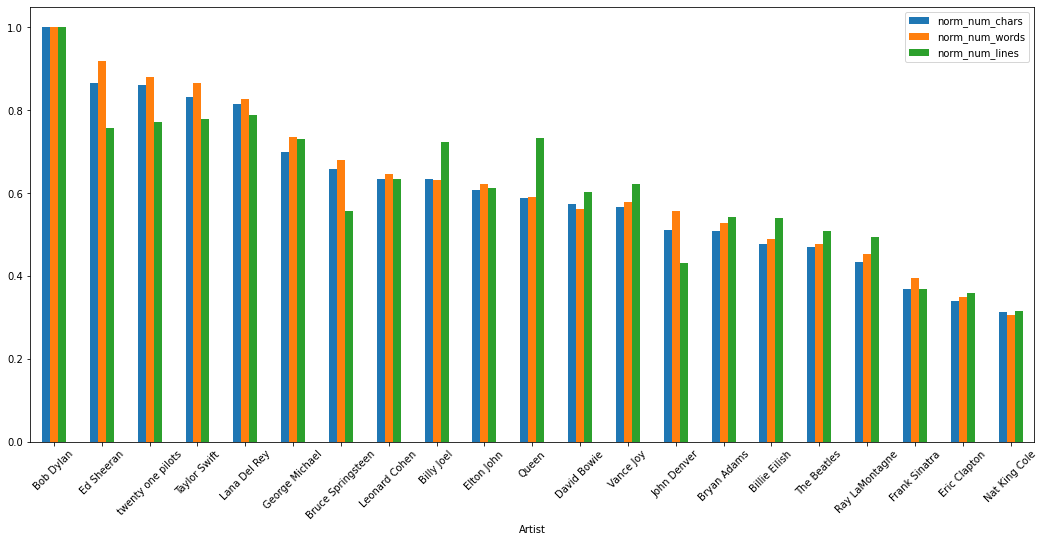

In [67]:
# Get avg lyric lengths
avg_lengths = all_lyrics.groupby('Artist').mean().sort_values(by='num_chars', ascending=False)


# Normalize
for col in avg_lengths.columns:
    avg_lengths['norm_' + col] = avg_lengths[col]/max(avg_lengths[col])

# Plot with rotated labels
avg_lengths.plot.bar(y=['norm_num_chars', 'norm_num_words', 'norm_num_lines'],
                     figsize=(18, 8), rot=45)

From this, we can see that Bob Dylan has the longest lyrics by every measure. He's followed by Ed Sheeran. Nat King Cole and Eric Clapton are on the other side of the spectrum. This is intuitive too, since Dylan and Sheeran are primarily vocalists while Clapton and Cole are known for their guitar and piano performances respectively.

This also tells us that there is substantial variance in the length of different artists lyrics.

Let us also look at number of unique words for each artist.


<function matplotlib.pyplot.show>

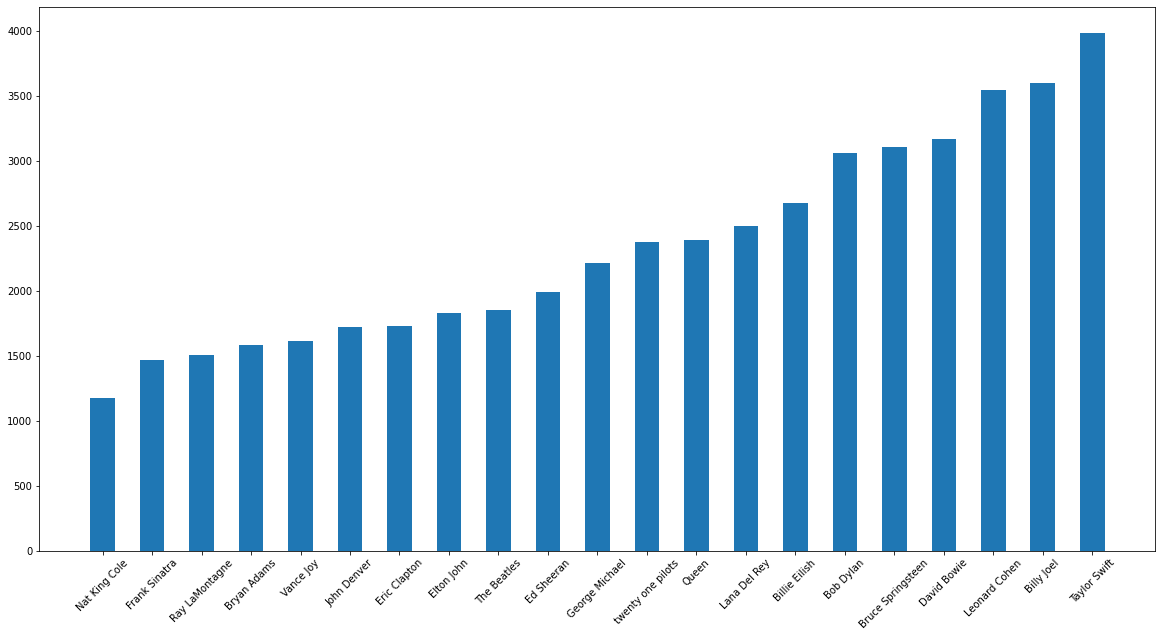

In [68]:
vocab_cnt = {}

for artist in all_lyrics['Artist'].unique():
    all_words = ' '.join(all_lyrics[all_lyrics['Artist']==artist]['Lyrics'])
    vocab_cnt[artist] = len(set(all_words.split(' ')))

vocab_cnt = dict(sorted(vocab_cnt.items(), key=lambda vocab_cnt: vocab_cnt[1]))

plt.rcParams["figure.figsize"] = (20,10)
plt.bar(range(len(vocab_cnt)), list(vocab_cnt.values()),
        align='center', width=0.5)
plt.xticks(range(len(vocab_cnt)), list(vocab_cnt.keys()), rotation=45)

plt.show

In the data that we are using, the artists vocabulary size varies from 1200 to almost 4000.

Since we can see that each artist will have their own unique vocabulary and style, let us use this pipeline to model each artist separately.

For simplicity, we will pick Ed Sheeran and Lana Del Rey as two of our choices. Reasons for picking these two is:
- Both have similarly high number of words per song
- Both have a moderate vocabulary size in this data
- This way, we can control variability due to these factors


# <a id='5'>Data Preparation<a>


Since this is a text generation task, there is no exlpicit validation that we can perform. The way to validate our models will be to look at training accuracy and of course judging the coherence and style of the generated texts. As such, there is no need to split the data -  we will use the entire corpus.

In [69]:
artists = ['Ed Sheeran', 'Lana Del Rey']
#artists = ['Billie Eilish', 'Taylor Swift']

masks = []
for artist in artists:
    masks.append(all_lyrics['Artist'] == artist)

We will filter down each artists lyrics into individual corpora.

In [70]:
# Using only a sample of the data to demonstrate concept
# This is due to server and compute power limitations

corpora = []
for mask in masks:
    corpus = '\n'.join(all_lyrics[mask]['Lyrics'])
    corpora.append(corpus)

Sample of the merged Ed Sheeran corpus:

In [71]:
corpora[0][:200]

"The club isn't the best place to find a lover\nSo the bar is where I go\nMe and my friends at the table doing shots\nDrinking fast and then we talk slow\nAnd you come over and start up a conversation with"

Sample of the merged Lana Del Rey corpus:

In [72]:
corpora[1][:200]

"I've seen the world, done it all\nHad my cake now\nDiamonds, brilliant, and Bel Air now\nHot summer nights, mid-July\nWhen you and I were forever wild\nThe crazy days, city lights\nThe way you'd play with m"

Now let us clean up the text by removing punctuations and newline characters. Before removing the punctuations, we will capture the distribution of these punctuations for each artists. This might come in handy later.

In [73]:
# Remove punctuations, extra spaces and make everything lower case
puncs = ['.', '?', ',', '"', '(', ')']
punc_counts = []
corpora_cln = []
all_sentences = []
for corpus in corpora:
    corpus_cln = corpus
    punc_cnt_dict = {}
    for punc in puncs:
        #print(f'Counting and replacing {punc}')
        punc_cnt_dict[punc] = corpus.count(punc)
        corpus_cln = corpus_cln.replace(punc, '')
    corpus_cln = corpus_cln.replace('\n\n', '\n')
    punc_counts.append(punc_cnt_dict)

    corpus_cln = corpus_cln.strip().lower()

    # Break down into sentences
    all_sentences.append(corpus_cln.split('\n'))
    corpora_cln.append(corpus_cln)

print(f'corpus[0] has {len(all_sentences[0])} sentences.')
print(f'corpus[1] has {len(all_sentences[1])} sentences.')
print(f'\nAdditionally, counts of different punctuations was:\n{punc_counts[0]}'
      f'\n{punc_counts[1]}')

corpus[0] has 1065 sentences.
corpus[1] has 1635 sentences.

Additionally, counts of different punctuations was:
{'.': 4, '?': 27, ',': 504, '"': 52, '(': 54, ')': 54}
{'.': 19, '?': 154, ',': 1032, '"': 88, '(': 223, ')': 223}


Now let us see what the top 20 words in each corpora are.

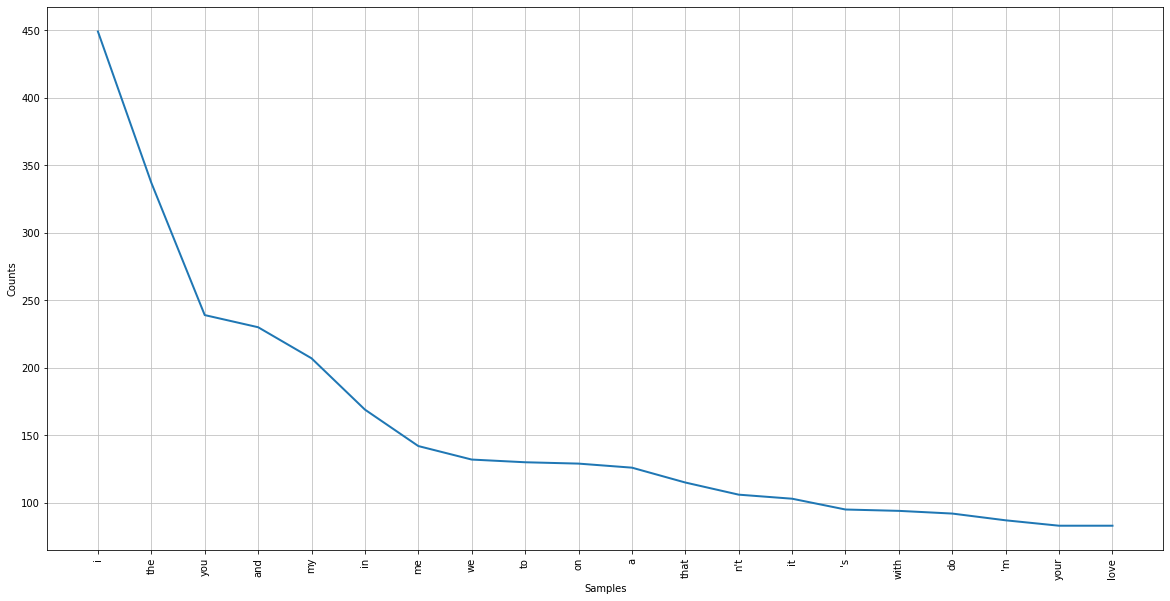

Ed Sheeran 



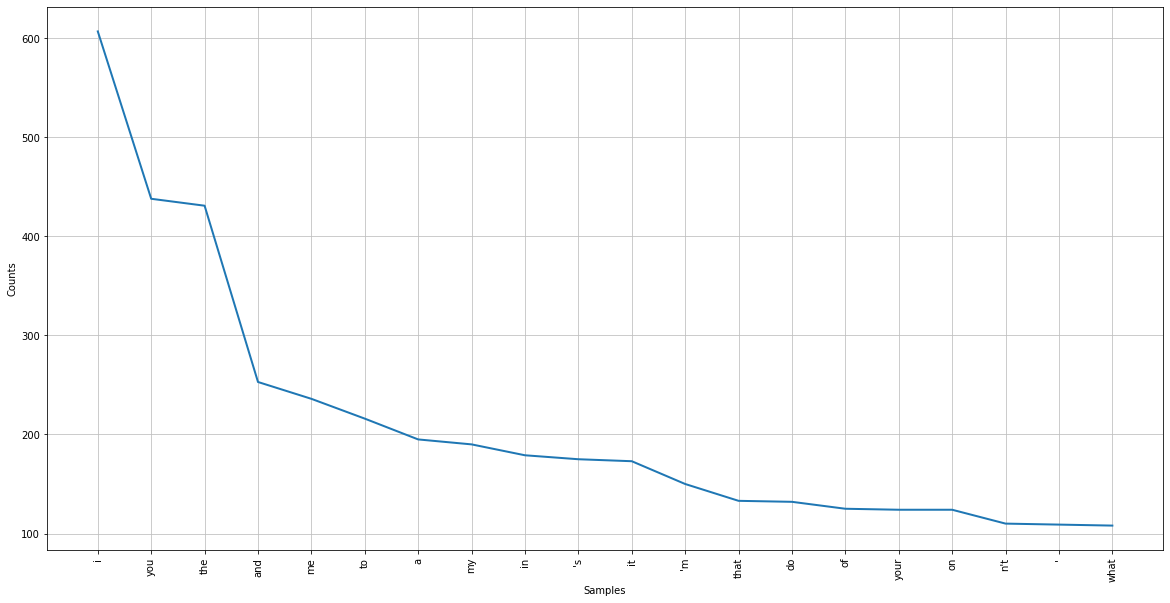

Lana Del Rey 



In [74]:
import nltk
#nltk.download('punkt')

def plot_top_words(text, top_n=20):
    tokens = nltk.tokenize.word_tokenize(text)
    fd = nltk.FreqDist(tokens)
    fd.plot(20, cumulative=False)

for corpus, artist in zip(corpora_cln, artists):
    plot_top_words(corpus)
    print(artist, '\n')

These look fairly standard. One thing to note is that the default nltk tokenizer splits contractions like ```don't``` to ```do``` and ```n't```. This is not required in our case. We should use a different tokenizer instead.

Now that we have the cleaned text, we need to convert it to numbers to feed to our model. We will do it in 2 steps:
- First, we will tokenize our words and map each word to an index. This will be a positive integer. Each word will have a unique token.
- When we build our model, we will use an embedding layer to convert these indices to a dense vector. When we train our model, we should be able to get the "correct" word embeddings for the words in each artist's vocabulary.


For the first step, we will use TensorFlow's ```Tokenizer```

In [90]:
# Text preprocessing imports from TF
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


tokenizers = []

for sentences in all_sentences:
    # Initiate Tokenizer using defaults values
    tokenizer = Tokenizer()
    # Fit Tokenizer on sentences
    tokenizer.fit_on_texts(sentences)
    tokenizers.append(tokenizer)

# print the first ten entries
print("The word_index dictionary has been built and looks like this:\n")
for word, idx in tokenizers[0].word_index.items():
  print(word, '\t', idx, end='\t\t\t')
  if idx%3 == 0:
      print()
  if idx == 15:
    break

The word_index dictionary has been built and looks like this:

the 	 1			i 	 2			and 	 3			
you 	 4			my 	 5			in 	 6			
me 	 7			to 	 8			on 	 9			
a 	 10			we 	 11			that 	 12			
with 	 13			i'm 	 14			love 	 15			


The above is based on Ed Sheeran's corpus. Lana Del Rey's will look similar.

Let us also check the vocabulary sizes for both corpora.

In [76]:
vocab_sizes = []

for tokenizer in tokenizers:
    # Add 1 to vocab size for the padding token
    vocab_sizes.append(len(tokenizer.word_index) + 1)

print(f'A vocabulary of {vocab_sizes} words was built')

A vocabulary of [1412, 1553] words was built


Both have a comparable size. Next, we will convert our sentences to sequences. This just means that we will change them from words to the indices representing these words.

Based on the ```word_index``` above, a sentence like ```'I'm in love with you'``` will become a sequence like ```[14, 6, 15, 13, 4]```

Additionally we will augment the actual sentences by creating additional n-gram sequences for each.

For the example above, some n-gram sequences will be:

```[14, 6]```

```[14, 6, 15]```

```[14, 6, 15, 13]```

This is because we want to train our model to predict the most likely next word. By creating these n-gram sequences, we provide the model additional data for doing exactly this.

In [77]:
from statistics import mean, stdev

def create_training_seqs(tokenizer, sentences):
    # Initiate empty lists
    training_seqs = []

    # Also measure the length of each sentence - to be used later
    sent_lens = []

    # Repeat for each sentence
    for sentence in sentences:
        # Convert a single sentence to a sequence of ints
        tokenized_sentence = tokenizer.texts_to_sequences([sentence])[0]
        sent_lens.append(len(tokenized_sentence))

        # For this sentence, create possible ngram sequences
        # Each ngram sequence will help build training data
        for i in range(1, len(tokenized_sentence)):
            ngram_seq = tokenized_sentence[:i+1]
            training_seqs.append(ngram_seq)
    mean_len = round(mean(sent_lens))
    stdev_len = round(stdev(sent_lens))
    print(f'\nAvg sentence is {mean_len} words long with a stdev of {stdev_len}')
    print(f'Created {len(training_seqs)} training sequences from sentences')
    training_seqs[:15]
    return training_seqs, mean_len, stdev_len

In [78]:
all_training_seqs = []
len_stats = []

for tokenizer, sentences in zip(tokenizers, all_sentences):
    training_seqs, mean_len, stdev_len = create_training_seqs(tokenizer,
                                                              sentences)
    all_training_seqs.append(training_seqs)
    len_stats.append(dict(mean=mean_len, stdev=stdev_len))



Avg sentence is 8 words long with a stdev of 3
Created 7095 training sequences from sentences

Avg sentence is 7 words long with a stdev of 3
Created 9785 training sequences from sentences


Now we have 7096 and 9792 training sequences for Ed Sheeran and Lana Del Rey respectively.

Additionally, we found out a bit about the average length and standard deviation for these 2 artists. We might use this information later on.


In [79]:
all_training_seqs[0][:15]

[[1, 356],
 [1, 356, 357],
 [1, 356, 357, 1],
 [1, 356, 357, 1, 495],
 [1, 356, 357, 1, 495, 245],
 [1, 356, 357, 1, 495, 245, 8],
 [1, 356, 357, 1, 495, 245, 8, 93],
 [1, 356, 357, 1, 495, 245, 8, 93, 10],
 [1, 356, 357, 1, 495, 245, 8, 93, 10, 358],
 [25, 1],
 [25, 1, 246],
 [25, 1, 246, 40],
 [25, 1, 246, 40, 94],
 [25, 1, 246, 40, 94, 2],
 [25, 1, 246, 40, 94, 2, 62]]

So we got our sequences, but they are all of different sizes. Regular tensors will not be able to handle this data. We have 2 options:

- Use Ragged Tensors
- Pad the data to make all sequences same length


We will use padding, since it is the simpler alternative for our task.
Addtionally, we will cap each sequence to 15 words. This will make it robust against outliers. Also, 15 is a reasonable value since it is more than double of the average sentence lengths.

In [80]:
# Pad training seqs to get them all to same length
max_lengths = []
all_padded_seqs = []
for training_seqs in all_training_seqs:
    max_length = min(max([len(x) for x in training_seqs]), 20)
    max_lengths.append(max_length)
    print(f'Max sequence length is {max_length} words')
    
    # Prefix padding
    padded_seqs = pad_sequences(training_seqs, maxlen=max_length,
                                padding='pre')
    all_padded_seqs.append(padded_seqs)

Max sequence length is 16 words
Max sequence length is 20 words


In [81]:
for padded_seqs in all_padded_seqs:
    print('\nNow the sequences look like this: ')
    print(padded_seqs[:15])


Now the sequences look like this: 
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   1 356]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   1 356 357]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1 356 357   1]
 [  0   0   0   0   0   0   0   0   0   0   0   1 356 357   1 495]
 [  0   0   0   0   0   0   0   0   0   0   1 356 357   1 495 245]
 [  0   0   0   0   0   0   0   0   0   1 356 357   1 495 245   8]
 [  0   0   0   0   0   0   0   0   1 356 357   1 495 245   8  93]
 [  0   0   0   0   0   0   0   1 356 357   1 495 245   8  93  10]
 [  0   0   0   0   0   0   1 356 357   1 495 245   8  93  10 358]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0  25   1]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  25   1 246]
 [  0   0   0   0   0   0   0   0   0   0   0   0  25   1 246  40]
 [  0   0   0   0   0   0   0   0   0   0   0  25   1 246  40  94]
 [  0   0   0   0   0   0   0   0   0   0  25   1 246  40  94   2]
 [  0   0   0   0   0   0 

Now we have the data that we need. As stated above, we will make this a prediction problem. To do this, we will separate the last index from the sequences above. This last index will be the label and the remaining part will act like our feature.

For example:

```[0, 0, 14, 6, 15, 13]``` will become ```[0, 0, 14, 6, 15] ``` + ```[13]```

Here, ```[0, 0, 14, 6, 15] ``` will be our feature and our label will be ```[13]```

Finally, we will convert our labels to categorical, by one-hot encoding them. This is needed becuase we want the model to be able to predict the probability of each word.

In [82]:
all_features = []
all_labels = []

for training_seqs, vocab_size in zip(all_padded_seqs, vocab_sizes):
    # Separate the seqs to feature and label
    features = training_seqs[:, :-1]
    labels = training_seqs[:, -1]

    # One hot encode the labels
    enc_labels = tf.keras.utils.to_categorical(labels, num_classes=vocab_size)

    print(features.shape, labels.shape, enc_labels.shape)
    all_features.append(features)
    all_labels.append(enc_labels)

(7095, 15) (7095,) (7095, 1412)
(9785, 19) (9785,) (9785, 1553)


From the shapes above, we can see that:

Each ```max_length``` word sequence has been broken down to a ```max_length - 1``` word input feature and a ```1``` word label. Additionally, the labels have been one-hot encoded, so that now the shape of labels is ```(num_of_seqs, vocab_size)```.


# <a id='6'>Modeling<a>


Data preparation is now complete. We will begin building our model.

As stated above, we will use the following layers:

- ```Embedding```: this will create dense vectors from our index sequences and also reduce dimensionality. Our input_dim will be equal to the size of our vocabulary. Output dimension of the embedding has been chosen as 250. This number was arrived at by rough experimentation - 250 is a good value since it serves to reduce the dimensionality significantly (from around 1500), while at the same time it is not so low that our words start losing meaning. Also, our input_length will be 14 (max_length - 1), since that's the length of each sequence.

- ```Bidirectional LSTM```: This will ensure that even far away words have a chance of providing context for the next prediction. Also, we will make it bidirectional so words far away on either side will still provide predictive power. We will use 150 as the number of units.

- ```Dropout```: This layer is helpful in curbing overfitting. We will randomly turn off 10% of the neurons.

- ```Dense```: This will be our output layer. Number of units will be equal to the number of labels - which is same as our vocabulary size. We will use a ```softmax``` activation function because we are predicting probabilities across multiple labels. This will ensure that the predictions sum up to 1.

Some other points to note:

 - While compiling, we will use ```categorical_crossentropy``` as the loss function, since our data is categorical. 

 - Our optimizer will be ```Adam```, since it is a good blend of fast computation and reasonable generalization. It is the go-to optimizer for most use-cases.

- While training, we will look at accuracy as a metric

- Anything not specified above will be left to default reasonably chosen values


Let us build these models and train them.



In [83]:
# TF imports for building a simple LTSM NN
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

models = []

for vocab_size, max_length in zip(vocab_sizes, max_lengths):
    # Build using sequential since each layer will have a single input and output tensor
    model = Sequential()

    # Embed each words positive int value to a dense vector
    model.add(Embedding(vocab_size, 200, input_length=max_length-1))

    # LSTM layer with arbitrary value of 150 units - up for experimentation
    # We will make the LSTM bidirectional, so that states are fed both ways
    model.add(Bidirectional(LSTM(150)))

    # Add dropout layer to tone down overfitting
    model.add(Dropout(0.05))

    # Dense output layer to get back probability of each word
    model.add(Dense(vocab_size, activation='softmax'))

    # Our labels are categorical, so categorical cross_entropy to be used
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Print out summary
    print('\n\n', model.summary())

    models.append(model)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 200)           282400    
                                                                 
 bidirectional (Bidirectiona  (None, 300)              421200    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense (Dense)               (None, 1412)              425012    
                                                                 
Total params: 1,128,612
Trainable params: 1,128,612
Non-trainable params: 0
_________________________________________________________________


 None
Model: "sequential_1"
_________________________________________________________________
 Layer (type)   

- We will train our models for 30 epochs. With more data, higher number of epochs may be needed, but for our small chunk of data and compute power, 30 is a fair amount.

- Before beginning training, we will also add an early stopping condition. If the loss doesn't decrease for 3 consecutive epochs, we will stop traiing further.


In [ ]:
histories = []
epochs = 30

# Early stopping condition
# To stop training if no reduction in loss for 3 consecutive epochs
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

for features, enc_labels, model in zip(all_features, all_labels, models):
    model_history = model.fit(features, enc_labels, epochs=epochs,
                              callbacks=[callback])
    histories.append(model_history)

Epoch 1/30
222/222 [==============================] - 31s 120ms/step - loss: 6.2425 - accuracy: 0.0409
Epoch 2/30
222/222 [==============================] - 22s 99ms/step - loss: 5.7100 - accuracy: 0.0557
Epoch 3/30
222/222 [==============================] - 20s 89ms/step - loss: 5.2518 - accuracy: 0.1032
Epoch 4/30
222/222 [==============================] - 20s 91ms/step - loss: 4.6836 - accuracy: 0.1604
Epoch 5/30
222/222 [==============================] - 20s 90ms/step - loss: 4.1240 - accuracy: 0.2271
Epoch 6/30
222/222 [==============================] - 29s 132ms/step - loss: 3.6051 - accuracy: 0.3015
Epoch 7/30
222/222 [==============================] - 20s 89ms/step - loss: 3.1355 - accuracy: 0.3687
Epoch 8/30
222/222 [==============================] - 20s 90ms/step - loss: 2.7250 - accuracy: 0.4317
Epoch 9/30
222/222 [==============================] - 22s 98ms/step - loss: 2.3436 - accuracy: 0.5035
Epoch 10/30
222/222 [==============================] - 20s 89ms/step - loss: 2.0


# <a id='7'>Evaluation<a>

Great, our models are now trained. We got roughly 87% and 80% accuracy on the training data, which is not bad at all, especially for the small amount of data and the basic network architecture. Remember that text generation is difficult problem to solve, especially with small amounts of data.


Let us plot the training history curves to see how our models improved over each epoch.

In [85]:
def plot_model_history(history, epochs):
    acc = history.history['accuracy']
    loss = history.history['loss']

    epochs_range = range(1, epochs + 1)

    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Accuracy')
    plt.legend(loc='lower right')
    plt.title('Model training accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Loss')
    plt.legend(loc='upper right')
    plt.title('Model training loss')
    plt.show()

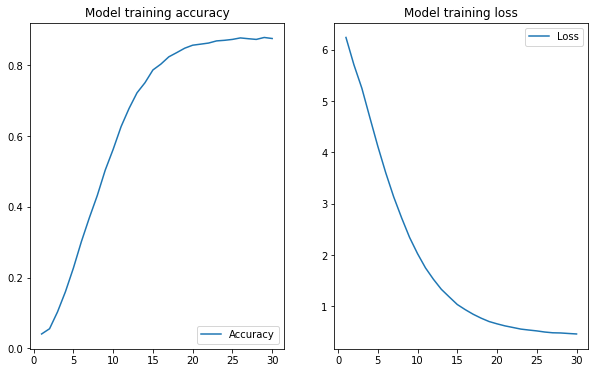

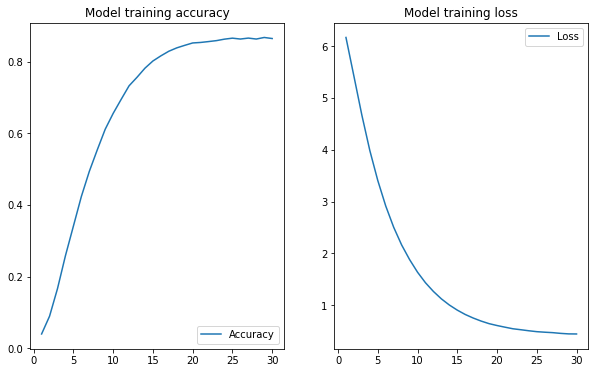

In [86]:
print('\n')
for history in histories:
    plot_model_history(history, epochs)
    print('\n\n')

As seen above, the models reached near peak accuracy at about 25 epochs itself. After that, the gain in accuracy slowed down. If we had trained longer and with more data, we could definitely have achived better results.

Since the training took quite a while, let us save the trained models, so we do not need to train again if we lose our session.

In [88]:
# Save the model to be used later
from tensorflow.keras.models import save_model

# CHANGE THIS IF YOU ARE NOT USING GOOGLE COLAB
base_path = '/content/drive/MyDrive/M508_models/'

for model, artist in zip(models, artists):
    model_name = 'lyrgen_' + str(epochs) + '_' + artist.replace(' ', '_').lower()
    model_path = base_path + model_name
    save_model(model, model_path, overwrite=True)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/M508_models/lyrgen_30_ed_sheeran/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/M508_models/lyrgen_30_ed_sheeran/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/M508_models/lyrgen_30_lana_del_rey/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/M508_models/lyrgen_30_lana_del_rey/assets


In [22]:
# Load the saved model
from tensorflow.keras.models import load_model

# CHANGE THIS IF YOU ARE NOT USING GOOGLE COLAB
base_path = '/content/drive/MyDrive/M508_models/'

models_loaded = []
for artist in artists:
    model_name = 'lyrgen_' + epochs + '_' + artist.replace(' ', '_').lower()
    model_path = base_path + model_name
    model_loaded = tf.keras.models.load_model(model_path)
    models_loaded.append(model_loaded)
    print(f'loaded model {model_name}')

loaded model lyrgen_50_billie_eilish
loaded model lyrgen_50_taylor_swift



# <a id='8'>Text Generation<a>

Now that we have te trained models, we will create a function which will use the model to predict the next word in a sequence, one word at a time.


Our function will also add a few nice touches to make it so that the output looks somewhat like a song lyric, as opposed to just a long string of words.

- Function will take the prediction model, seed text, number of sentences to generate and the len_stat we gathered earlier

- Using the len_stat, the model will vary the lengths of sentences and punctuations to make the lyric more organic and closer to source

- Through experimentation, it was also noticed that in a small number of cases, the model might get stuck predicing the same word again and again

- For such cases, the function has a logic to not pick the same word twice - if the best predicted word is same as last predicted word, the function will instead go for the second best predicted word

- Once required number of sentences are built, it will return the generated text

In [107]:
import random

def generate_text(model, seed_text, num_sents, len_stat, max_length):
    # Initiate helper vars
    last2_idx = (None, None)
    init = True
    puncs = ['', ',', '.', ';']
    punc_probs = [0.5, 0.3, 0.1, 0.1]
    min_snt_len = len_stat['mean'] - int((0.5 * len_stat['stdev']))
    max_snt_len = len_stat['mean'] + int((0.5 *len_stat['stdev']))

    # Loop to generate num_sent sentences
    for i in range(1, num_sents + 1):
        snt_len = random.randint(min_snt_len, max_snt_len)
        cursor = 0
        if i == 1:
            cursor = len(seed_text.split(' '))
        while cursor <= snt_len:
            # Convert seed text to seed sequence
            token_list = tokenizer.texts_to_sequences([seed_text])[0]
            seed_sequence = pad_sequences([token_list], maxlen=max_length-1,
                                            padding='pre')

            # Get array of predictions
            predictions = model.predict(seed_sequence)[0]

            # Get top 3 preditions
            #top2_idx = predictions.argsort()[-2:]
            top3_idx = predictions.argsort()[-3:]

            # Avoid predicting same words in a row
            while(top3_idx[-1] in last2_idx):
                top3_idx = top3_idx[:-1]
            pred_idx = top3_idx[-1]
            
            pred_word = ""
            # Get the word from the index
            for word, idx in tokenizer.word_index.items():
                if idx == pred_idx:
                    pred_word = word
                    break

            # Add predicted word to seed next iteration
            # First word of sentence
            if cursor == 0:
                pred_word = pred_word.title()
            # Continuation of sentence
            else:
                pred_word = ' ' + pred_word

            seed_text += pred_word

            # Reached end of sentence
            if cursor == snt_len:
                # Stanza after every 4 lines
                if i%4 == 0 or i == num_sents:
                    seed_text += '.\n'
                else:
                    seed_text += random.choices(puncs, punc_probs, k=1)[0]
                seed_text += '\n'

            # Update last_token, increment cursor
            last2_idx = last2_idx[1], pred_idx
            cursor += 1

    return seed_text

Finally! Let us test what we have built.

We will use 2 seed texts as prompts and generate 8 lines from both the models

In [108]:
# Change if loaded from elsewhere
models_to_test = models

In [112]:
# Scenario 1
seed_text1 = 'Blue sky'
num_sents = 8
for model, artist, len_stat, max_length in zip(models_to_test, artists,
                                               len_stats, max_lengths):
    print(f'"{seed_text1}" in the style of {artist}\n')
    print(generate_text(model, seed_text1, num_sents, len_stat, max_length))

"Blue sky" in the style of Ed Sheeran

Blue sky la get would your i honey
My life off hands but y on a this only,
Your see anthem for i'm if beautiful get i'm;
Later'S my better right high in the parliament's.

Lover a you i'm already on death you,
I please oh will baby do wha don't had say;
Favors milly will baby tears had to used the enough.
Give talk baby me because you i yes your that.


"Blue sky" in the style of Lana Del Rey

Blue sky and i get high on my party,
Top out hop time out of my;
Time ooh and use talking freedom is,
Time to people even in the night of.

Freedom that people i know a couldn’t stars in,
The freedom that sustained me to a sky,
But people i couldn’t to have living they,
Asked me but there’s no use in.




- While as a whole, the lyrics are not very coherent, some phrases are!

- The style and chosen words are quite distinct for each model

- Also, since we did not filter for any profanity, we can expect some explicit words in the generated text

Let us try another prompt.

In [113]:
# Scenario 2
seed_text2 = 'I\'m sorry'
num_sents = 12

for model, artist, len_stat, max_length in zip(models_to_test, artists,
                                               len_stats, max_lengths):
    print(f'"{seed_text2}" in the style of {artist}\n')
    print(generate_text(model, seed_text2, num_sents, len_stat, max_length))

"I'm sorry" in the style of Ed Sheeran

I'm sorry baby the one anything you the
Trying made my the ivy on me pouring.
Lover you a got i'm high but a my i'm
Niggas cover beautiful i've leave and life for touch.

But had my i'm greatest cared revolution hard queen already,
Mean queen favors stopped sitting woodstock stopped niggas.
Woodstock stopped will baby though shit he's woodstock,
Niggas as baby i'm niggas cover woodstock lover will.

Though baby design lover you streets fake will hold
Dying wha i'm sitting good i slowly where me long,
Niggas 'n' early niggas have132embedshare woodstock stopped sitting you'll,
Of she's souls somebody baby tears somebody the.


"I'm sorry" in the style of Lana Del Rey

I'm sorry that i'm misbehaving with you 'til,
Get him 'til beautiful and crying side the,
Stars of the only things night i know
It in know what i know that i.

Had that asked but they asked but true
People in the people in the freedom is the,
Only time to the night sky and
Night it su

These samples are a bit more coherent. It is a bit hard to quantify, but  we can definitely see the artists public personas reflected in these lyrics.


# <a id='9'>Conclusion<a>


Though far from perfect, this is an interesting pipeline. It is highly adaptable. All we need is an artist and some text representing their work. 

There is an obvious lack of coherence at a larger level, but on a smaller level, many phrases make sense. This was to be expected due to the simple architecture and lack of adequate data.


In summary, this is an area that is promising and definitely worth pursuing. Further improvements can be made using:

- More data
- Better cleaning the data
- A more complex and better tuned model (using BERT perhaps)
- Adding rhyme scheme data
- Using POS tags to increase coherence
- Using song titles/genre for topic modeling to augment word selection


The most interesting thing about this kind of a pipeline is that the model is not aware at all about the language it has learnt. In other words, such a pipeline can be easily adapted to other domains and languages - for writing poems, writing prose, or with enough clean data, it could even write logical programming code - the possibilities are truly endless!



# <a id='10'>References<a>


- Dataset sourced from https://www.kaggle.com/datasets/karnikakapoor/lyrics

- Dataset hosted at https://raw.githubusercontent.com/FzQureshi/Datasets/main/Songs.csv

- TF Docs: https://www.tensorflow.org/api_docs/python/tf

- LSTM Text generation: https://www.analyticsvidhya.com/blog/2021/08/text-generation-using-bidirectional-lstm-a-walk-through-in-tensorflow/

- Malmi, E., Takala, P., Toivonen, H., Raiko, T. and Gionis, A. (2016). DopeLearning: A Computational Approach to Rap Lyrics Generation. Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining - KDD ’16, [online] pp.195–204. doi:10.1145/2939672.2939679.

- Cover image: https://djmag.com/news/world%E2%80%99s-first-artificial-intelligence-music-producer-has-arrived
‌